In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/iyzico-projesi/samplesubmission.csv
/kaggle/input/iyzico-projesi/train.csv
/kaggle/input/iyzico-projesi/test.csv


Firstly, we will create train and test data sets. 

In [2]:
import matplotlib.pyplot as plt

train_data = pd.read_csv("/kaggle/input/iyzico-projesi/train.csv")
test_data = pd.read_csv("/kaggle/input/iyzico-projesi/test.csv")

Now, let us view features and targets of train and test data. 

In [3]:
train_data.head()

,BASKETPAIDPRICE,BASKETINSTALLMENT,BASKETPAYMENTCHANNEL,BASKETPAYMENTSOURCETYPE,BASKETISTHREEDS,BASKETREGISTERCARD,BASKETHASVIRTUALITEM,CARDTYPE,CARDASSOCIATION,EMAIL,CARDBANKID,MERCHANT_ID,ISFRAUD
0,0.220099,1,9,1,1,0,0,1,1,1403000,7,6679,0
1,-0.173116,1,1,1,1,0,1,1,1,902058,7,8220,0
2,-0.228070,1,9,1,0,0,0,1,1,1454563,0,4698,0
3,-0.098923,1,2,1,0,0,0,1,2,1708531,7,28,0
4,-0.059801,3,1,3,1,0,0,1,1,1832048,4,694,0


In [4]:
train_data.tail()

,BASKETPAIDPRICE,BASKETINSTALLMENT,BASKETPAYMENTCHANNEL,BASKETPAYMENTSOURCETYPE,BASKETISTHREEDS,BASKETREGISTERCARD,BASKETHASVIRTUALITEM,CARDTYPE,CARDASSOCIATION,EMAIL,CARDBANKID,MERCHANT_ID,ISFRAUD
159995,0.034138,1,9,1,0,0,1,1,2,1204736,9,1282,0
159996,1.444032,2,1,3,1,0,0,1,2,1024242,9,1868,0
159997,-0.071446,1,5,3,1,0,0,1,1,671844,8,2498,0
159998,-0.018938,1,1,1,0,0,1,1,2,425769,7,958,0
159999,-0.023576,2,5,3,0,0,0,1,1,127601,15,4917,0


In [5]:
train_data.shape

(160000, 13)

So, train data has 160000 has data value and 12 features. The last column indicates the target values. The column of `ISFLAUD` is target column.

In [6]:
test_data.tail()

,ID,BASKETPAIDPRICE,BASKETINSTALLMENT,BASKETPAYMENTCHANNEL,BASKETPAYMENTSOURCETYPE,BASKETISTHREEDS,BASKETREGISTERCARD,BASKETHASVIRTUALITEM,CARDTYPE,CARDASSOCIATION,EMAIL,CARDBANKID,MERCHANT_ID
39995,39995,0.028286,3,1,3,1,0,0,1,2,452624,12,694
39996,39996,0.107783,1,1,1,1,0,1,1,1,822951,7,1733
39997,39997,-0.017294,1,1,1,0,0,0,1,1,1103635,7,31
39998,39998,-0.226133,1,5,1,0,0,1,1,2,1429491,9,774
39999,39999,-0.263298,1,9,1,0,0,0,2,1,671845,1,7622


In [7]:
test_data.shape

(40000, 13)

In the data set, the features of `EMAIL`, `CARDBANKID`, `MERCHANT_ID` have not huge effects on prediction of transactions. Because, we don't interest persons who perform transactions, interest only process of transaction. Therefore, we can drop these columns from the train data set. 

In [8]:
train_data = train_data.drop(["EMAIL", "CARDBANKID", "MERCHANT_ID"], axis= 1)

Now, we check `NaN` values whether exist or not in the data set. 

In [9]:
count = 0
for row in range(train_data.shape[0]):
    for column in range(train_data.shape[1]):
        if pd.isnull(train_data.iloc[row, column]) == True:
            count += 1
        else:
            continue

if count == 0:
    print('There is no NaN value in the data set')

There is no NaN value in the data set


Now, we can process the clean data. We will Recurrent Neural Network for predicstion. In the Recurrent Neural Network, the method which we use for prediction is LSTM. 

Before struct the network, let us split data(train.csv) for train and test. We will control the strength of the model based on accuracy and loss. Then, we will use updated weigths with the neural network for prediction of data values in the test(test.csv) data. 

In the data set, some features have '0' categorical values. This situation may bring about some problems for compiling the model. So, we will add 1 to all values of some features. 

In [10]:
features = train_data.iloc[:, :-1]
target = train_data.iloc[:, -1]

In [11]:
features.shape

(160000, 9)

In [12]:
target.shape

(160000,)

In [13]:
import random

from sklearn.model_selection import train_test_split
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.33, random_state = random.randrange(0,100))

In [14]:
count = 0

for index in range(len(test_target)):
    if target[index] == 1:
        count += 1
        
print(count)

838


In [15]:
train_features.shape

(107200, 9)

We need to expand dimension of the train and test features in order to construct suitable network for the data. 

In [16]:
train_features = np.expand_dims(train_features, axis = 2)
test_features = np.expand_dims(test_features, axis = 2)

In [17]:
train_features.shape

(107200, 9, 1)

In [18]:
import keras 

train_target = keras.utils.to_categorical(train_target)
test_target = keras.utils.to_categorical(test_target)

Using TensorFlow backend.


In [19]:
train_target.shape

(107200, 2)

Now, let us create the network. 

In [20]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential 
from keras.regularizers import l1, l2, l1_l2

It is input layer of the network.

In [21]:
model = Sequential()

There are four hidden layers in the network. `input_shape` indicates the shape of previous layer. In the first hidden layer, `input_shape` must be assigned as dimension of input layer. The `ReLu` function is used as non-linear activation function in all hidden layers. 

In [22]:
#model.add(LSTM(50, return_sequences=True, input_shape=(train_features.shape[1], 1), activation='tanh'))
model.add(Dense(64, input_shape=(train_features.shape[1], 1), activation = 'relu', kernel_regularizer='l2'))
model.add(Dense(16, activation = 'tanh'))
model.add(Dense(4, activation = 'relu'))


model.add(Flatten())
#model.add(LSTM(50, return_sequences=True, activation='relu'))
#model.add(LSTM(50, return_sequences=True, activation='tanh'))
#model.add(LSTM(50, return_sequences=False, activation='tanh'))

The final stage of constructing the architecture of the network is setting output layer. 

In [23]:
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(2, activation = 'sigmoid', kernel_regularizer='l2'))

We used `l2 regularization` at output layer and one hidden layer to reduce effect of overfitting. Because, a gap between train and test curves has occured without `l2 regularization`. The gap was reduced with `l2 regularization`. 

We constructed the network. Now, we must compile with optimizer and loss functions 

In [24]:
opt_param = keras.optimizers.Adam(learning_rate=0.000001)
model.compile(loss='binary_crossentropy', optimizer = opt_param, metrics=['accuracy'])

Default value of the learning rate is reduced to 0.000001 because the loss and the accuracy values did not change during epochs. This means that the model could not learn anything from data. 

At the final stage, we are fitting with paramaters of `batch_size` and `epoch`. 

In [25]:
ann = model.fit(train_features, train_target, batch_size=1024, epochs=20, validation_data=(test_features, test_target))

Train on 107200 samples, validate on 52800 samples
Epoch 1/20
107200/107200 [==============================] - 1s 14us/step - loss: 0.7257 - accuracy: 0.7100 - val_loss: 0.7250 - val_accuracy: 0.7114
Epoch 2/20
107200/107200 [==============================] - 1s 9us/step - loss: 0.7249 - accuracy: 0.7105 - val_loss: 0.7243 - val_accuracy: 0.7119
Epoch 3/20
107200/107200 [==============================] - 1s 9us/step - loss: 0.7242 - accuracy: 0.7111 - val_loss: 0.7236 - val_accuracy: 0.7125
Epoch 4/20
107200/107200 [==============================] - 1s 9us/step - loss: 0.7235 - accuracy: 0.7115 - val_loss: 0.7228 - val_accuracy: 0.7128
Epoch 5/20
107200/107200 [==============================] - 1s 9us/step - loss: 0.7227 - accuracy: 0.7120 - val_loss: 0.7221 - val_accuracy: 0.7132
Epoch 6/20
107200/107200 [==============================] - 1s 9us/step - loss: 0.7220 - accuracy: 0.7125 - val_loss: 0.7213 - val_accuracy: 0.7136
Epoch 7/20
107200/107200 [==============================] - 

Text(0.5, 1.0, 'Accuracy Curves')

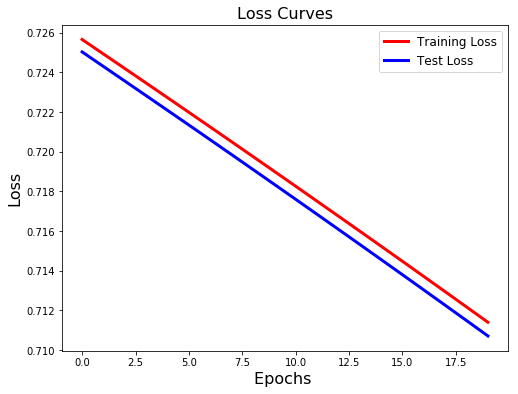

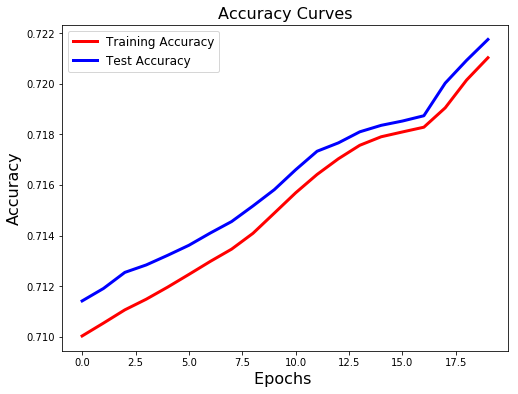

In [26]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
train_loss, = plt.plot(ann.history['loss'],'r',linewidth=3.0)
test_loss, = plt.plot(ann.history['val_loss'],'b',linewidth=3.0)
plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
train_accuracy, = plt.plot(ann.history['accuracy'],'r',linewidth=3.0)
test_accuracy, = plt.plot(ann.history['val_accuracy'],'b',linewidth=3.0)
plt.legend([train_accuracy, test_accuracy], ['Training Accuracy', 'Test Accuracy'],fontsize=12)

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

At the end of 40 epochs, the validation accuracy is around 0.95 and the validation loss is 0.66. The curves of train and test are close to each other and there is no considerable gap between two curves in both accuracy and loss values. Therefore, we can say that there is no overfitting or underfitting. This model can be used for predicting. 

In [27]:
test_data.head()

,ID,BASKETPAIDPRICE,BASKETINSTALLMENT,BASKETPAYMENTCHANNEL,BASKETPAYMENTSOURCETYPE,BASKETISTHREEDS,BASKETREGISTERCARD,BASKETHASVIRTUALITEM,CARDTYPE,CARDASSOCIATION,EMAIL,CARDBANKID,MERCHANT_ID
0,0,-0.030406,1,9,1,0,0,1,1,2,95248,8,163
1,1,-0.261830,1,9,1,0,0,1,2,1,1123807,15,6945
2,2,0.135299,1,4,3,0,0,0,1,1,878540,7,1232
3,3,-0.002224,1,1,1,0,0,1,1,1,755894,8,1733
4,4,-0.197247,1,9,1,0,0,1,1,2,1123807,9,6945


In [28]:
test_data = test_data.drop(["EMAIL", "CARDBANKID", "MERCHANT_ID", "ID"], axis=1)

In [29]:
test_data = np.expand_dims(test_data, axis = 2)

In [30]:
test_data.shape

(40000, 9, 1)

Test data is ready for predicting. Let us predict target values with the network model which we created. 

In [31]:
prediction = model.predict(test_data)

In [32]:
prediction

array([[0.42550525, 0.42994493],
       [0.43384594, 0.42101467],
       [0.48500255, 0.46847787],
       ...,
       [0.5336221 , 0.47377977],
       [0.44935742, 0.44634414],
       [0.45501435, 0.4233385 ]], dtype=float32)

We need to classes for `ISFRAUD`. So, we use `predict_classes` function belongs to the model. 

In [33]:
prediction_classes = model.predict_classes(test_data)

In [34]:
predictions = list(prediction_classes)

We will create a data frame, then write this data frame to csv file. 

In [35]:
result_df = pd.DataFrame(columns = ['ID', 'ISFRAUD'])

In [36]:
transaction_id = []

for index in range(0, len(predictions)):
    transaction_id.append(index)

In [37]:
result_df['ID'] = transaction_id
result_df['ISFRAUD'] = predictions

In [38]:
result_df.head()

,ID,ISFRAUD
0,0,1
1,1,0
2,2,0
3,3,0
4,4,1


In [39]:
result_df.tail()

,ID,ISFRAUD
39995,39995,0
39996,39996,0
39997,39997,0
39998,39998,0
39999,39999,0


Finally, the last submission file is created.

In [40]:
result_df.to_csv('last_submission2.csv', index = False)